In [1]:
import numpy
import pandas

import conntility

from matplotlib import pyplot as plt
from distribution import sis, cut_zeros_and_shift
from fitting import optimize_touch_model


fn_rat = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Rat_623um_squared_struc_conmat_filtered_compressed.h5"
fn_human = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_960um_squared_struc_conmat_filtered_compressed.h5"

loaded = "human"  # Set to human to analyze that instead

if loaded == "rat":
    M_h = conntility.ConnectivityMatrix.from_h5(fn_rat)
elif loaded == "human":
    M_h = conntility.ConnectivityMatrix.from_h5(fn_human)

M_h.vertices

,index,population,node_ids,etype,layer,morphology,mtype,synapse_class,x,y,z,ss_flat_x,depth,ss_flat_y
0,0,hncx_neurons,0,PYR_L23,L2,685814252_-_Scale_x1.000_y1.050_z1.000,L23_PTPC,EXC,779.973032,2255.463864,1538.881747,1267.973032,352.536136,1562.881747
1,1,hncx_neurons,1,PYR_L23,L2,665713811_-_Scale_x1.000_y1.025_z1.000,L23_PTPC,EXC,1076.796974,2245.365871,865.911045,1564.796974,362.634129,889.911045
2,6,hncx_neurons,6,PYR_L23,L2,758319694,L23_PTPC,EXC,601.192085,2085.837710,1382.693416,1089.192085,522.162290,1406.693416
3,11,hncx_neurons,11,PYR_L23,L2,602165685,L23_PTPC,EXC,757.470091,2226.168333,984.828784,1245.470091,381.831667,1008.828784
4,12,hncx_neurons,12,PYR_L23,L2,596898838_-_Scale_x1.000_y0.975_z1.000,L23_PTPC,EXC,821.995965,2247.111072,1240.299471,1309.995965,360.888928,1264.299471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20017,107471,hncx_neurons,107471,PYR_L23,L3b,1067_H38_01_160113_cell2_-_Scale_x1.000_y0.950...,L23_STPC,EXC,542.088822,1522.737173,1432.527308,1030.088822,1085.262827,1456.527308
20018,107480,hncx_neurons,107480,PYR_L23,L3b,685815936_-_Scale_x1.000_y0.975_z1.000,L23_STPC,EXC,832.459351,1668.380689,798.964852,1320.459351,939.619311,822.964852
20019,107481,hncx_neurons,107481,PYR_L23,L3b,685815936_-_Scale_x1.000_y1.050_z1.000,L23_STPC,EXC,370.294247,1571.087143,1452.238771,858.294247,1036.912857,1476.238771
20020,107487,hncx_neurons,107487,PYR_L23,L3b,1081_H42-10,L23_STPC,EXC,832.873951,1644.785453,870.675550,1320.873951,963.214547,894.675550


In [2]:
# Some meta-parameters

max_touch_count = 100
n_dist_bins = 9
num_edges_last_bin = 5000

In [3]:
# Add distance and distance bin information to the edges

sum_deltas = numpy.zeros(len(M_h.edges))

for axis in ["x", "y", "z"]:
    prop = M_h.edge_associated_vertex_properties(axis)
    delta = prop["row"].values - prop["col"].values
    sum_deltas += (delta ** 2)

M_h.add_edge_property("distance", numpy.sqrt(sum_deltas))

# Linear distance bins (for now)
tgt_percentile = 100 * (1.0 - 5000 / len(M_h.edges))
max_dist = numpy.percentile(M_h.edges["distance"], tgt_percentile)

dbins = numpy.linspace(0, max_dist, n_dist_bins)
bin_centers = dbins + 0.5 * numpy.mean(numpy.diff(dbins))
M_h.add_edge_property("bin", numpy.digitize(M_h.edges["distance"], bins=dbins) - 1)

In [4]:
# Optimize the model

opt_params, opt_model = optimize_touch_model(M_h.edges, bin_centers, max_num_touches=max_touch_count)

Number of args to optimize: 6
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


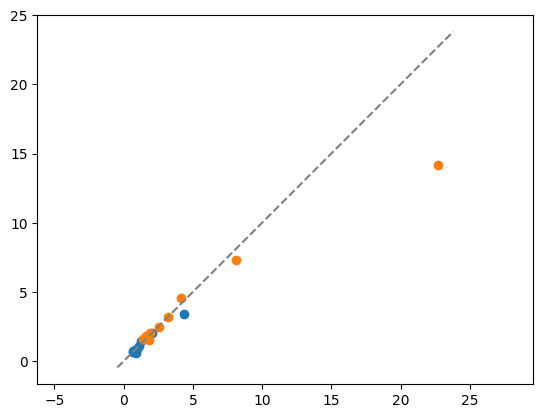

In [5]:
# Validation 1: Mean and variance of extra touches (beyond the first) in each distance bin

# Data
mean_extra_edges = M_h.edges.groupby("bin")["count"].mean().values - 1
var_extra_edges = M_h.edges.groupby("bin")["count"].var().values

# Model
mdl, _ = cut_zeros_and_shift(sis(opt_model["i"], opt_model["f"], opt_model["p"], max_touch_count))
mn, var = mdl.stats()

plt.plot(mean_extra_edges, mn, 'o')
plt.plot(var_extra_edges, var, 'o')
plt.axis("equal")
plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), ls="--", color="grey")

(-1.0, 50.0)

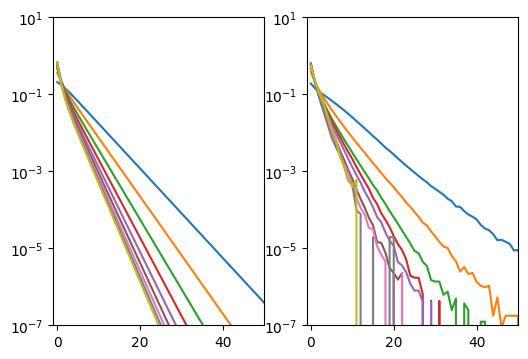

In [7]:
# Validation 2: Touch count distributions

extra_touches = numpy.arange(0, max_touch_count + 1)

prob_data = M_h.edges.groupby("bin")["count"].apply(lambda x: 
                                                    pandas.Series(numpy.histogram(x - 1, bins=extra_touches,
                                                                                  density=True)[0],
                                                                  index=pandas.Index(extra_touches[:-1], name="touches")))

prob_model = pandas.concat([pandas.Series(mdl.pmf(_x), index=pandas.Index(range(n_dist_bins), name="bin"))
                            for _x in extra_touches[:-1]],
                          keys=extra_touches[:-1], names=["touches"])
                                                  

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(1, 2, 1); ax2 = fig.add_subplot(1, 2, 2)

_ = ax1.plot(prob_model.unstack("bin"))
_ = ax2.plot(prob_data.unstack("bin"))

ax1.set_yscale('log')
ax1.set_ylim((1E-7, 10))
ax1.set_xlim((-1, 50))

ax2.set_yscale('log')
ax2.set_ylim((1E-7, 10))
ax2.set_xlim((-1, 50))